In [12]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import shutil 


batch_size= 64

mean = -0.1
std=1
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../datasets/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([32, 32]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../datasets/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([32, 32]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=16, shuffle=False, drop_last= True)

for x,y in train_loader:
    break
    
vmin= x.min().item()
vmax= x.max().item()
print('range : ',vmin, vmax)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
range :  0.10000000149011612 1.100000023841858


In [13]:
import torch
import shutil 
import numpy as np
from torch import nn
from modules.kernels import get_gaussian
from modules.models.decoder import simple_generator
from modules.models.forward_model import forward_modelA
from modules.models.forward_H import modelH
from modules.train_utils import train
from modules.custom_activations import inc_m
import matplotlib.pyplot as plt
from modules.models.preprocess_H_weights import ifft_2d_with_fftshift_real
from modules.noise import poisson_noise
from modules.models.classifiers import simple_mnist_classifier

device='cuda' if torch.cuda.is_available() else 'cpu'

classifier = simple_mnist_classifier(32).to(device)
classifier.load_state_dict(torch.load('saved_models/mnist_classifier.pth', map_location=device)['model_state_dict'])

<All keys matched successfully>

In [14]:
img_size= 32
m_inc_epoc= 1

def inc_1_after_60_interval_10(m, epoch):
    if epoch>60 and epoch%10==0:
        m=inc_m(m, epoch, 1)
    return m

sPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)
exPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)

criterion= nn.L1Loss().to(device)
train_model_iter, train_H_iter= 1, 1

## Test run

In [15]:
'''
from modules.custom_activations import sigmoid_custom as H_activation

T=5
H_init= 'fft'
H_weight_preprocess= ifft_2d_with_fftshift_real
m_inc_proc =inc_1_after_100_interval_10

decoder= simple_generator(T, img_size).to(device)
opt_model= torch.optim.Adam(decoder.parameters(), lr= 0.001)

H_generator = modelH(T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, device = device, initialization_bias=0, activation = H_activation, init_method= H_init).to(device)
opt_H= torch.optim.Adam(H_generator.parameters(), lr= 0.01)

noise=True # gradient exploding is not there (because I have added change the image range [1,2] -> which not contains 0s in it: forward_model.py)
train_model_iter, train_H_iter= 1, 1

train(decoder, forward_modelA, H_generator, sPSF, exPSF, criterion, [opt_model, opt_H], train_loader, test_loader, device, T, 10, 1, train_model_iter, train_H_iter, m_inc_epoc, m_inc_proc, './1', noise, classifier, [mean, std])

'''

"\nfrom modules.custom_activations import sigmoid_custom as H_activation\n\nT=5\nH_init= 'fft'\nH_weight_preprocess= ifft_2d_with_fftshift_real\nm_inc_proc =inc_1_after_100_interval_10\n\ndecoder= simple_generator(T, img_size).to(device)\nopt_model= torch.optim.Adam(decoder.parameters(), lr= 0.001)\n\nH_generator = modelH(T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, device = device, initialization_bias=0, activation = H_activation, init_method= H_init).to(device)\nopt_H= torch.optim.Adam(H_generator.parameters(), lr= 0.01)\n\nnoise=True # gradient exploding is not there (because I have added change the image range [1,2] -> which not contains 0s in it: forward_model.py)\ntrain_model_iter, train_H_iter= 1, 1\n\ntrain(decoder, forward_modelA, H_generator, sPSF, exPSF, criterion, [opt_model, opt_H], train_loader, test_loader, device, T, 10, 1, train_model_iter, train_H_iter, m_inc_epoc, m_inc_proc, './1', noise, classifier, [mean, std])\n\n"

## Experiments

In [16]:
save_path= 'figs/test'


!rm -rf $save_path
!mkdir $save_path

In [17]:
n_gpus = torch.cuda.device_count()
print(f'n_gpus : {n_gpus}')

n_gpus : 0




RUNNING EXPERIMENT :: figs/test/noise(True)@T(16)@lr_H(0.5)@torch_seed(100)
device : cpu
m : 1
yt range (train): [0.0002371072769165039 0.7812699675559998]
yt range (test): [0.0010251551866531372 0.8021668791770935]
training loop time (for single epoch): 425.4229040145874 sec
show images : X range : [0.10000000149011612, 1.100000023841858]
show images : X_hat range : [0.03436450660228729, 1.2840033769607544]
X.min, X.max, X_hat.min, X_hat.max (after normalization):  tensor(0.) tensor(1.) tensor(0.) tensor(1.)


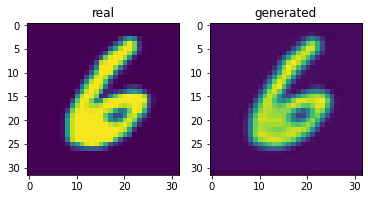

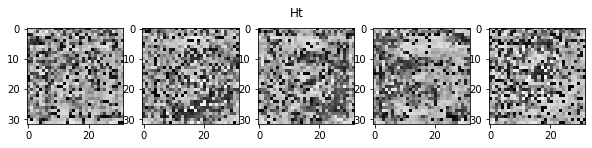

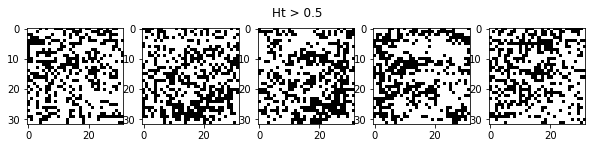

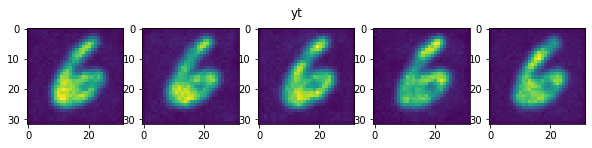

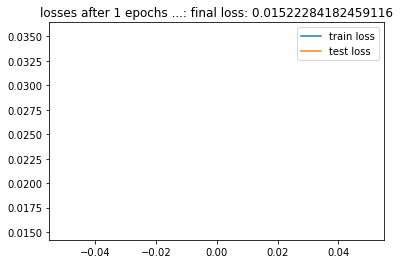

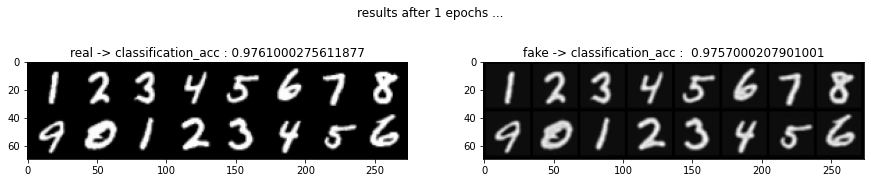

m : 1
yt range (train): [-0.0013797972351312637 0.9521705508232117]
yt range (test): [0.0030998094007372856 0.9258288145065308]
training loop time (for single epoch): 421.32840299606323 sec
show images : X range : [0.10000000149011612, 1.100000023841858]
show images : X_hat range : [0.07254915684461594, 1.2872710227966309]
X.min, X.max, X_hat.min, X_hat.max (after normalization):  tensor(0.) tensor(1.) tensor(0.) tensor(1.)


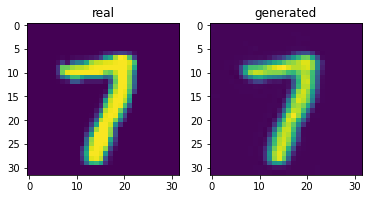

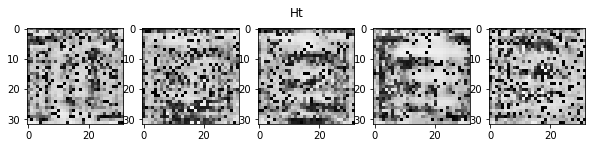

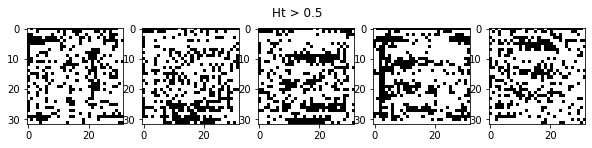

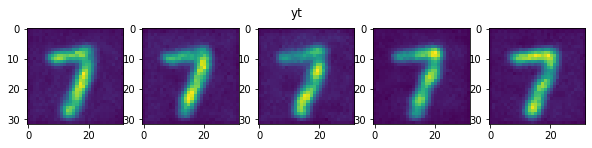

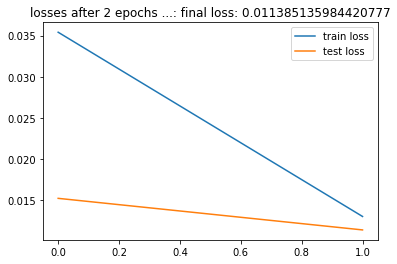

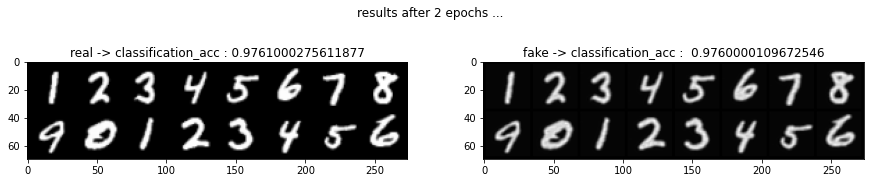

m : 1
yt range (train): [0.001452272292226553 0.984394371509552]
yt range (test): [0.001402934081852436 0.9878629446029663]
training loop time (for single epoch): 422.11450695991516 sec
show images : X range : [0.10000000149011612, 1.100000023841858]
show images : X_hat range : [0.0772939920425415, 1.2773029804229736]
X.min, X.max, X_hat.min, X_hat.max (after normalization):  tensor(0.) tensor(1.) tensor(0.) tensor(1.)


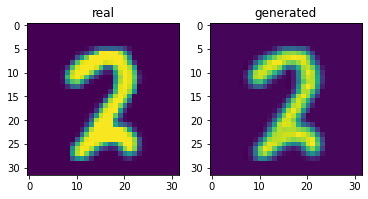

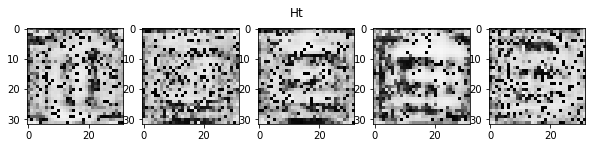

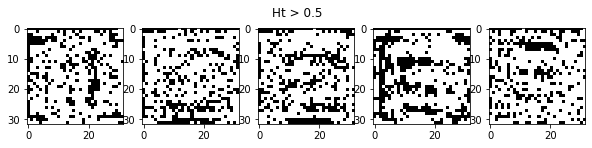

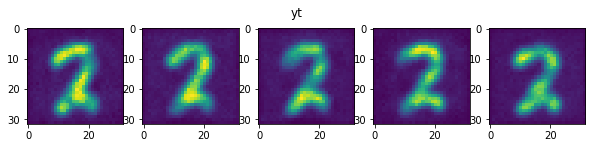

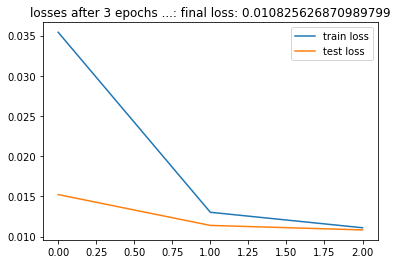

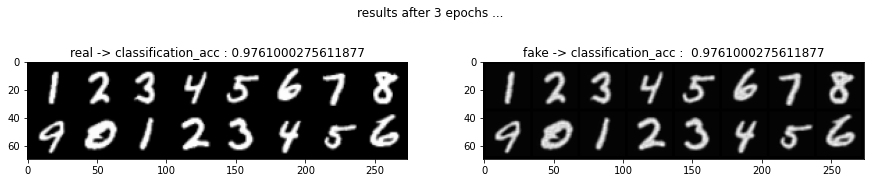

m : 1
yt range (train): [-0.0014141425490379333 0.9773551225662231]
yt range (test): [0.0016788933426141739 0.9921135306358337]
training loop time (for single epoch): 420.5732510089874 sec
show images : X range : [0.10000000149011612, 1.100000023841858]
show images : X_hat range : [0.08482963591814041, 1.2278450727462769]
X.min, X.max, X_hat.min, X_hat.max (after normalization):  tensor(0.) tensor(1.) tensor(0.) tensor(1.)


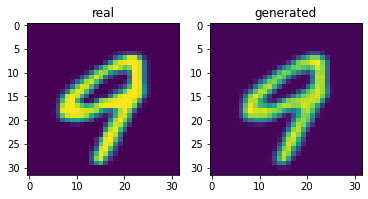

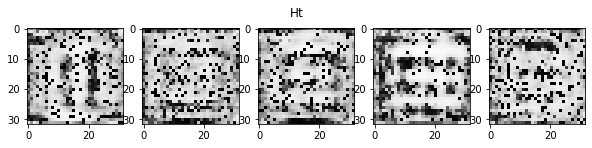

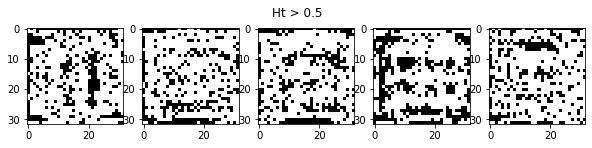

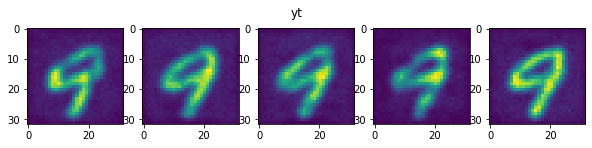

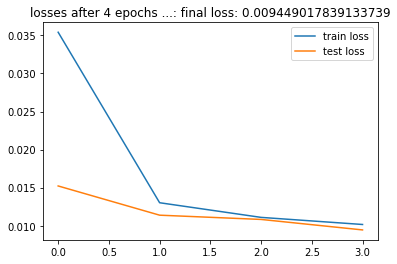

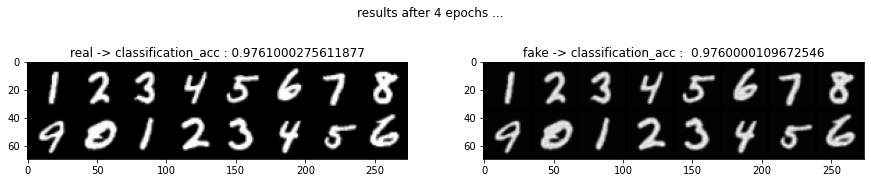

m : 1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [18]:
from modules.custom_activations import sigmoid_custom


H_init = 'fft'
H_complex_init= False #override by H_init
H_weight_preprocess= ifft_2d_with_fftshift_real
m_inc_proc =  inc_1_after_60_interval_10
initialization_bias= 0
H_activation= sigmoid_custom
noise_K=1000

epochs=10
show_results_epoch=1

Ts=[16]
noises= [True]
lrs_H= [0.0000001, 0.5, 0.1]
torch_seeds= [100, 101]

for noise in noises:
    for T in Ts:
        for lr_H in lrs_H:
            for torch_seed in torch_seeds:
                if lr_H==0.0000001:continue
                try:
                    if H_weight_preprocess ==None:H_weight_preprocess_name = 'None'
                    else:H_weight_preprocess_name = H_weight_preprocess.__name__
                    if m_inc_proc==None:m_inc_proc_name = 'None'
                    else:m_inc_proc_name = m_inc_proc.__name__

                    save_dir= f'{save_path}/noise({noise})@T({T})@lr_H({lr_H})@torch_seed({torch_seed})'
                    print(f'\n\nRUNNING EXPERIMENT :: {save_dir}')

                    try:shutil.rmtree(save_dir)
                    except:pass

                    torch.manual_seed(torch_seed) #3
                    
                    if n_gpus<=1:
                        decoder= simple_generator(T, img_size).to(device)
                    else:
                        decoder= nn.DataParallel(simple_generator(T, img_size)).to(device)
                    opt_model= torch.optim.Adam(decoder.parameters(), lr= 0.001)

                    torch.manual_seed(torch_seed) #13
                    H_generator = modelH(T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, complex_init=H_complex_init, device = device, initialization_bias=initialization_bias, activation = H_activation, init_method= H_init).to(device)
                    opt_H= torch.optim.Adam(H_generator.parameters(), lr= lr_H)

                    train(decoder, forward_modelA, H_generator, sPSF, exPSF, criterion, [opt_model, opt_H], train_loader, test_loader, device, T, epochs, show_results_epoch, train_model_iter, train_H_iter, m_inc_epoc, m_inc_proc, save_dir, noise, classifier, [mean, std], noise_K)


                except Exception as e:
                    print(f'ERROR :: {save_dir} :: {e}')
                    pass

In [ ]:
# loop: (1gpu): training loop time (for single epoch): 29.820760488510132 sec
# loop: (2gpu): training loop time (for single epoch): 30.838639736175537 sec
